# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'dat-kmeans'
epochs = 10
batch_size = 8
sequence_length = 256

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctors-answer-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [8]:
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=256, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [10]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [11]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [12]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [13]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [14]:
def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    model.eval()
    start_time = time.time()
    embeddings = []
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    collected_indices = set()  # Initialize set to store selected indices

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        num_of_candidates = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    
        # Determine number of clusters
        if num_of_candidates <= n_clusters and n_clusters < nearest_cp - current_train_size:
            n_clusters = n_clusters
        elif num_of_candidates > n_clusters and num_of_candidates < nearest_cp - current_train_size:
            n_clusters = num_of_candidates
        else:
            arrived_at_cp = True
            n_clusters = nearest_cp - current_train_size
            
        kmeans=KMeans(n_clusters=n_clusters, n_init=1)
        kmeans.fit(embeddings)
    
        if current_train_size > checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Samples above threshold:", num_of_candidates)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]  # Indices of samples in the current cluster
                
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances to the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
                closest_sample_index = cluster_indices[np.argmin(cluster_distances)]  # Closest sample index
                collected_indices.add(closest_sample_index)

            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'pornografi': [y_train[i][0] for i in temp],
                    'sara': [y_train[i][1] for i in temp],
                    'radikalisme': [y_train[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train[i][3] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Samples above threshold:", num_of_candidates)
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

# MAIN LOOP

In [15]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [16]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6763, Accuracy: 0.9137, F1 Micro: 0.937, F1 Macro: 0.6684
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5134, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3771, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3077, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2581, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2449, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2255, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1898, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1761,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5987, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3649, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2668, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2024, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1731, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1886, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1705, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.145, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1443, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5127, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2615, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1886, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1574, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1542, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.132, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.112, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4911, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2591, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1841, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1167, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1332, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.114, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1214,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4436, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2084, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1581, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1469, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1275, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1173, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1013

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4032, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1923, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1734, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1646, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1382, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.118, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 8/10, Train Loss: 0.1372, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1015, Accuracy: 0.9688, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3861, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1684, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.155, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1468, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 7/10, Train Loss: 0.1181, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1043, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 9/10, Train Loss: 0.0897, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3792, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1865, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1582, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1526, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1478, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 7/10, Train Loss: 0.121, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 8/10, Train Loss: 0.0985, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Epoch 9/10, Train Loss: 0.1114, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 10/10, Train Loss: 0.0696, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3691, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1709, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1568, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1504, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7227
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0789, Accuracy: 0.9732, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3742, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1817, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1637, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1743, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.126, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Epoch 8/10, Train Loss: 0.1148, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 9/10, Train Loss: 0.0903, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7219
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3604, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1835, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1651, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.162, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1285, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 7/10, Train Loss: 0.1217, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0984, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0843, Accuracy: 0.9717, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3604, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1955, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1553, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.1088, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0946, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0862, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3456, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1772, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1526, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1498, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1355, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 6/10, Train Loss: 0.1176, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7551
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.9613, F1 Micro: 0.971, F1 Macro: 0.7271
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7902
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3529, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1836, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1681, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.1317, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Epoch 7/10, Train Loss: 0.1013, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0851, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7569
Epoch 9/10, Train Loss: 0.064, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7962
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3409, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1721, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1835, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6559
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.7735
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0678, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7789
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3396, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1816, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1676, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.151, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 6/10, Train Loss: 0.135, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 7/10, Train Loss: 0.1104, Accuracy: 0.9643, F1 Micro: 0.9727, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7781
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3248, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1774, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1606, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1475, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.1403, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6532
Epoch 7/10, Train Loss: 0.1011, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0743, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 10/10, Train Loss: 0.0577, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3254, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1943, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1652, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1475, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 5/10, Train Loss: 0.1243, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7236
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.0688, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7568
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7521
Epoch 10/10, Train Loss: 0.0573, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3291, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.186, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.169, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1426, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.1412, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7942
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7569
Epoch 10/10, Train Loss: 0.0619, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3274, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1687, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1576, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1352, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 6/10, Train Loss: 0.1154, Accuracy: 0.9628, F1 Micro: 0.9713, F1 Macro: 0.6512
Epoch 7/10, Train Loss: 0.0945, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7652
Epoch 8/10, Train Loss: 0.0709, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.7532
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.7493
Epoch 10/10, Train Loss: 0.0572, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2988, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1714, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1703, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1438, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.1351, Accuracy: 0.9613, F1 Micro: 0.9703, F1 Macro: 0.6506
Epoch 7/10, Train Loss: 0.0942, Accuracy: 0.9643, F1 Micro: 0.9727, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.083, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.768
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3083, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1831, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1646, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1414, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1482, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1147, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7569
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.781
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2996, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1729, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.15, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1415, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1194, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7781
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0673, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7988
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7458
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3217, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1667, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1754, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1266, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7236
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7457
Epoch 9/10, Train Loss: 0.0596, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7569
Epoch 10

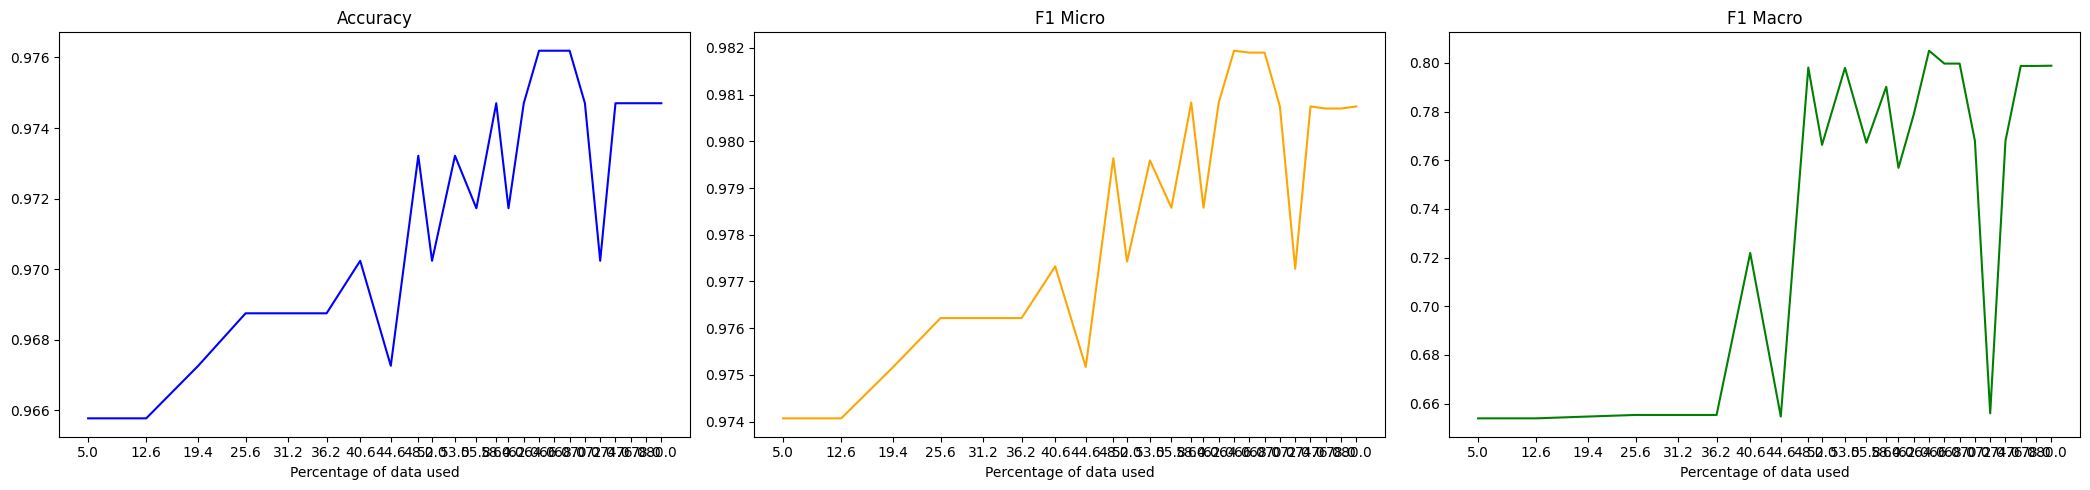

In [17]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7235, Accuracy: 0.9062, F1 Micro: 0.9317, F1 Macro: 0.6599
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5261, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4066, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3144, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2468, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.256, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1764, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1686, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2063,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6367, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3534, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2317, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2032, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2033, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1608, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1595, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1707, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1553,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5097, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2519, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1965, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1642, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1558, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1115, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1294, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1406,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.493, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2216, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1983, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1485, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1825, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1297, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1424, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1034, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4531, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1991, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.154, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.178, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1416, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1306, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.125, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0941, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4096, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1998, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1559, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1604, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1558, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1317, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 8/10, Train Loss: 0.1354, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6532
Epoch 9/10, Train Loss: 0.0969, Accuracy: 0.9643, F1 Micro: 0.9724, F1 Macro: 0.652
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4101, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2036, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1694, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1636, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1518, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1378, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 8/10, Train Loss: 0.1118, Accuracy: 0.9598, F1 Micro: 0.969, F1 Macro: 0.6495
Epoch 9/10, Train Loss: 0.1106, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3907, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2068, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1813, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1564, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1504, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.6486
Epoch 8/10, Train Loss: 0.1211, Accuracy: 0.9613, F1 Micro: 0.9701, F1 Macro: 0.6503
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1069, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3702, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1811, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1695, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1591, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 6/10, Train Loss: 0.1443, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Epoch 7/10, Train Loss: 0.1109, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1083, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 9/10, Train Loss: 0.095, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7502
Epoch 10/10, Train Loss: 0.0689, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3574, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1749, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1719, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1444, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1154, Accuracy: 0.9598, F1 Micro: 0.969, F1 Macro: 0.6495
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 9/10, Train Loss: 0.0743, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0631, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3588, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1946, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1594, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1589, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1252, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6531
Epoch 8/10, Train Loss: 0.1027, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7394
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7227
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.354, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1853, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1719, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1504, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 7/10, Train Loss: 0.1333, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.099, Accuracy: 0.9613, F1 Micro: 0.9701, F1 Macro: 0.6503
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0849, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7663
Epoch 10/10, Train Loss: 0.0765, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3251, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1883, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1721, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1125, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 8/10, Train Loss: 0.0695, Accuracy: 0.9658, F1 Micro: 0.9735, F1 Macro: 0.7186
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3411, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.165, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1832, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1372, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7228
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7554
Epoch 9/10, Train Loss: 0.0697, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.795
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3344, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2019, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1614, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1422, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1298, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 6/10, Train Loss: 0.1182, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6532
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.7182
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.9643, F1 Micro: 0.973, F1 Macro: 0.7321
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.7933
Epoch 10/10, Train Loss: 0.0596, Accuracy: 0.9598, F1 Micro: 0.9692, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3355, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1757, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1481, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1679, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.129, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1165, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7395
Epoch 8/10, Train Loss: 0.0954, Accuracy: 0.9628, F1 Micro: 0.9718, F1 Macro: 0.7367
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9613, F1 Micro: 0.9709, F1 Macro: 0.7301
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3324, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1782, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1625, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1137, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.7636
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7209
Epoch 9/10, Train Loss: 0.0675, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7554
Epoch 10/10, Train Loss: 0.0457, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3118, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1809, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1487, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.6577
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6532
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7294
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9568, F1 Micro: 0.9675, F1 Macro: 0.7244
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.747
Epoch 10/10, Train Loss: 0.0486, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3304, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1717, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1693, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1364, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.6525
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7794
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7877
Epoch 10/10, Train Loss: 0.0485, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3066, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1902, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1682, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1454, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.1484, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7661
Epoch 7/10, Train Loss: 0.088, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.755
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0397, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3118, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1822, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1566, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1411, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7663
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3149, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1865, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1674, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.141, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.1077, Accuracy: 0.9688, F1 Micro: 0.9765, F1 Macro: 0.7666
Epoch 7/10, Train Loss: 0.0977, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.7631
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7514
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7514
Epoch 10/10, Train Loss: 0.0536, Accuracy: 0.9658, F1 Micro: 0.974, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3041, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.183, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1488, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1443, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.779
Epoch 7/10, Train Loss: 0.0885, Accuracy: 0.9613, F1 Micro: 0.9701, F1 Macro: 0.7732
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.799
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.8003
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2915, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1606, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1692, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.1127, Accuracy: 0.9613, F1 Micro: 0.971, F1 Macro: 0.7271
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0964, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7669
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.7902
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9673, F1 Micro: 0.9748, F1 Macro: 0.7941
Epoch 10

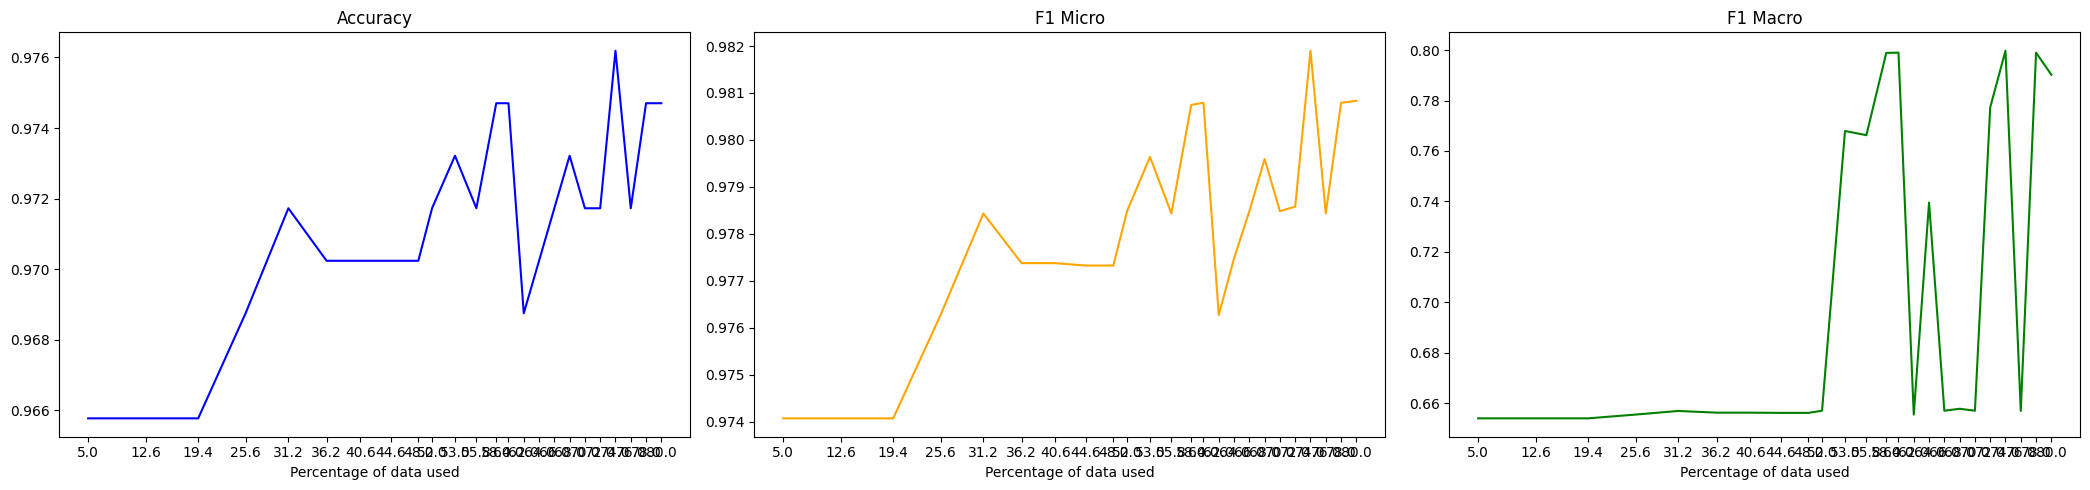

In [18]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6137, Accuracy: 0.9524, F1 Micro: 0.9635, F1 Macro: 0.6457
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4556, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3444, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2833, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.248, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1986, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2051, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1908, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1674,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5496, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3293, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2351, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1877, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1748, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1462, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1527, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1157, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1445,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.456, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2398, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1651, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1382, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1014, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1274, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4424, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2371, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1671, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1521, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1052, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.1448, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6531
Epoch 9/10, Train Loss: 0.1063, Accuracy: 0.9554, F1 Micro: 0.9657, F1 Macro: 0.6472
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4197, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.223, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1849, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1426, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1211, Accuracy: 0.9628, F1 Micro: 0.9717, F1 Macro: 0.6521
Epoch 8/10, Train Loss: 0.1257, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1033, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3763, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1941, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1693, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1436, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6531
Epoch 7/10, Train Loss: 0.1275, Accuracy: 0.9613, F1 Micro: 0.9703, F1 Macro: 0.6508
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Epoch 9/10, Train Loss: 0.0847, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0883, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3673, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1764, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.164, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1542, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1401, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1377, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Epoch 7/10, Train Loss: 0.0966, Accuracy: 0.9568, F1 Micro: 0.9666, F1 Macro: 0.6476
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0993, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0922, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3433, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1848, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1709, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1548, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.142, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1227, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6559
Epoch 8/10, Train Loss: 0.1095, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Epoch 9/10, Train Loss: 0.0828, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 10/10, Train Loss: 0.07, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.337, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1813, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1558, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.155, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1317, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0882, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 9/10, Train Loss: 0.0843, Accuracy: 0.9673, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3368, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1953, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1542, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1622, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1068, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6552
Epoch 9/10, Train Loss: 0.0652, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6561
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3223, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1866, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1565, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1354, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 7/10, Train Loss: 0.1092, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6559
Epoch 8/10, Train Loss: 0.0811, Accuracy: 0.9554, F1 Micro: 0.9663, F1 Macro: 0.6774
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7107
Epoch 10/10, Train Loss: 0.0531, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3147, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1742, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1644, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1185, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.9554, F1 Micro: 0.9654, F1 Macro: 0.6466
Epoch 8/10, Train Loss: 0.0975, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Epoch 9/10, Train Loss: 0.0818, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6552
Epoch 10/10, Train Loss: 0.0627, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3189, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2048, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1752, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1575, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1315, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.111, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Epoch 8/10, Train Loss: 0.0774, Accuracy: 0.9613, F1 Micro: 0.9702, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0646, Accuracy: 0.9717, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3206, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1721, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1782, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1364, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1324, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1143, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0984, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.070

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3068, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1823, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1804, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1586, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1228, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6552
Epoch 8/10, Train Loss: 0.0836, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.7209
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7386
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3113, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1913, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1529, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1484, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1318, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 6/10, Train Loss: 0.1373, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.655
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 8/10, Train Loss: 0.0911, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6545
Epoch 9/10, Train Loss: 0.0641, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0569, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3069, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1802, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1519, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1328, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 6/10, Train Loss: 0.1124, Accuracy: 0.9613, F1 Micro: 0.9702, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6559
Epoch 8/10, Train Loss: 0.0704, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7036
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7227
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2975, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1736, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.163, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1381, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6559
Epoch 6/10, Train Loss: 0.1248, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.0757, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.7219
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.9628, F1 Micro: 0.9719, F1 Macro: 0.7109
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0388, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2902, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1757, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1509, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1372, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1344, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7038
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7394
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9717, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2893, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1809, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1724, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.149, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.099, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7221
Epoch 8/10, Train Loss: 0.0753, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0678, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.768
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2953, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1772, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1612, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1413, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1067, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7801
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.78
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2998, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1747, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1668, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 6/10, Train Loss: 0.1163, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.082, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7669
Epoch 8/10, Train Loss: 0.0793, Accuracy: 0.9717, F1 Micro: 0.9783, F1 Macro: 0.7969
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.767
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2789, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1938, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1607, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1489, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1448, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6558
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1158, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7243
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.9688, F1 Micro: 0.9759, F1 Macro: 0.7206
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7982
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2862, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1729, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1691, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1622, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.144, Accuracy: 0.9539, F1 Micro: 0.9641, F1 Macro: 0.6452
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1376, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.7376
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7689
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.9717, F1 Micro: 0.9783, F1 Macro: 0.7969
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.9717, F1 Micro: 0.9783, F1 Macro: 0.7967
Epoch 10/10, Train Loss: 0.0458, Accuracy:

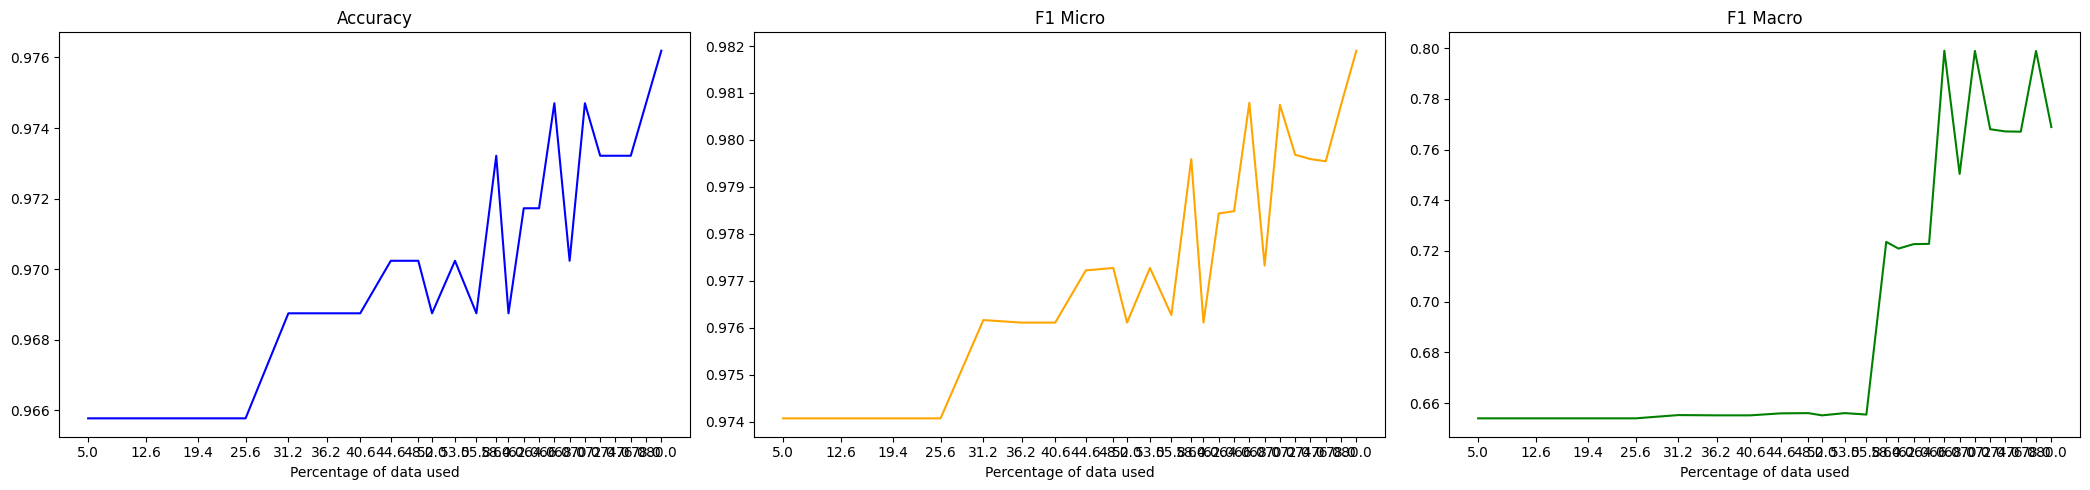

In [19]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6047, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.441, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3257, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3014, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2584, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.245, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.184, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1922, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1935, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5173, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3237, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2447, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2146, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2038, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1864, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1732, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1453, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1898,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4327, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2268, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1802, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.171, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1363, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1325, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1875, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1501, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4109, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2165, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1817, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1701, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1631, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1563, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1506, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1597,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3814, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1791, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1697, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1516, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1503, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1189, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1331, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.1079, Accuracy: 0.9628, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.353, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1868, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1642, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1601, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1397, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1385, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1466, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.126, Accuracy: 0.9628, F1 Micro: 0.9718, F1 Macro: 0.6522
Epoch 9/10, Train Loss: 0.1388, Accuracy: 0.9613, F1 Micro: 0.9706, F1 Macro: 0.6514
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.33, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1913, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1535, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1502, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1395, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.1108, Accuracy: 0.9568, F1 Micro: 0.9671, F1 Macro: 0.6487
Epoch 9/10, Train Loss: 0.1113, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6531
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3307, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1863, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1414, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1561, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1384, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1449, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.116, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6531
Epoch 9/10, Train Loss: 0.1013, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.6525
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3029, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1705, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1722, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1335, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1533, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.1285, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Epoch 9/10, Train Loss: 0.08, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6531
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3123, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1555, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1465, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1417, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1413, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.122, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1391, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.1107, Accuracy: 0.9598, F1 Micro: 0.9694, F1 Macro: 0.6505
Epoch 9/10, Train Loss: 0.1047, Accuracy: 0.9643, F1 Micro: 0.9728, F1 Macro: 0.6528
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.293, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1657, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1576, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1338, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1247, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1112, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0834, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2986, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1494, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1376, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.139, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1434, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9628, F1 Micro: 0.9718, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0963, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7108
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.9643, F1 Micro: 0.973, F1 Macro: 0.7445
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2891, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1641, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1361, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1345, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1158, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 9/10, Train Loss: 0.0741, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.721
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2901, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1614, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1553, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1138, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0858, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7973
Epoch 9/10, Train Loss: 0.0665, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7952
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2828, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1704, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1672, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1386, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.9613, F1 Micro: 0.9702, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0965, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7974
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.064, Accuracy: 0.9732, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2909, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1676, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1697, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1325, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1672, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1312, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7206
Epoch 7/10, Train Loss: 0.1111, Accuracy: 0.9598, F1 Micro: 0.9698, F1 Macro: 0.7253
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7463
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9688, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2671, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1732, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1532, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1513, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1504, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1428, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1095, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7213
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7643
Epoch 9/10, Train Loss: 0.067, Accuracy: 0.9643, F1 Micro: 0.9728, F1 Macro: 0.7634
Epoch 10/10, Train Loss: 0.0537, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2812, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1542, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1629, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1285, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1363, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0927, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7506
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0852, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7679
Epoch 9/10, Train Loss: 0.0685, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7657
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3003, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1566, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1603, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.156, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.9613, F1 Micro: 0.9704, F1 Macro: 0.6509
Epoch 7/10, Train Loss: 0.1099, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.7606
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0933, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.799
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2671, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1689, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1392, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1506, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1539, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1571, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1162, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.7776
Epoch 9/10, Train Loss: 0.0655, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7359
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2786, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1518, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1533, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1352, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7665
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro: 0.7506
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2597, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1732, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1585, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1481, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1484, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1227, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7228
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7643
Epoch 8/10, Train Loss: 0.0801, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7566
Epoch 9/10, Train Loss: 0.06, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7864
Epoch 10/10, Train Loss: 0.0511, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2654, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1598, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1641, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1501, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.121, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7876
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.7606
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7866
Epoch 10/10, Train Loss: 0.0396, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2794, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.168, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1431, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1364, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7221
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.7625
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9613, F1 Micro: 0.9706, F1 Macro: 0.742
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.8179
Epoch 10/10, Train Loss: 0.0408, Accuracy: 0.

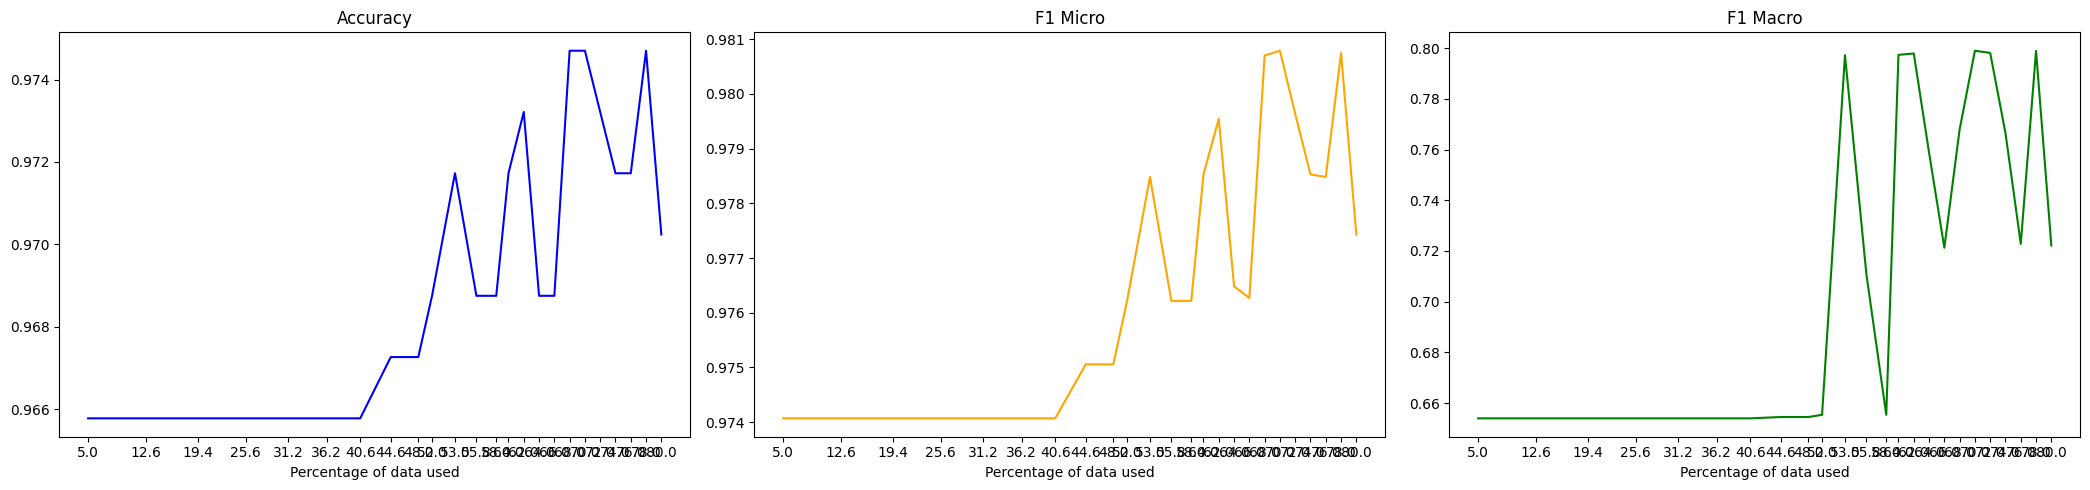

In [20]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6824, Accuracy: 0.933, F1 Micro: 0.9506, F1 Macro: 0.6659
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4587, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3581, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3132, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2816, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2517, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2263, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2142, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.225, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5797, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3367, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.27, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.209, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2102, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1578, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1815, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1512, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1917, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.464, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1973, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.174, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1428, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1013, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0942, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4567, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2061, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1679, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1817, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1745, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.137, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1826, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1503, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4049, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2084, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.177, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1596, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1688, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.157, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1696, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1201, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.111, Accuracy: 0.9658, F1 Micro: 0.974, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3884, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1877, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1845, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1443, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1536, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1396, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1399, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.135, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1162, Accuracy: 0.9702, F1 Micro: 0.977

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.365, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2128, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1582, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1455, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1283, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1502, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1317, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 9/10, Train Loss: 0.1157, Accuracy: 0.9673, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3446, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1688, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1521, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1526, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.127, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 8/10, Train Loss: 0.1224, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 9/10, Train Loss: 0.1033, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 10/10, Train Loss: 0.0962, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3418, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1618, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1686, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1246, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1214, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0983, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 9/10, Train Loss: 0.1007, Accuracy: 0.9583, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3411, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1625, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1554, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1264, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1294, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.0996, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 9/10, Train Loss: 0.0824, Accuracy: 0.9643, F1 Micro: 0.973, F1 Macro: 0.7274
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3296, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1644, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1373, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1499, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.13, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1434, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1206, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1076, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 9/10, Train Loss: 0.0813, Accuracy: 0.9702, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3302, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1701, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1639, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.132, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.1293, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1023, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1007, Accuracy: 0.9702, F1 Micro: 0.977

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3152, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1646, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.145, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.0903, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.316, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.171, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1548, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.166, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1409, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1181, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0673, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3026, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1653, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1492, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1431, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1356, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1137, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.055

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3085, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1599, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1593, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1201, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.1108, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6559
Epoch 8/10, Train Loss: 0.0975, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2889, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1806, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1607, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1513, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1376, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1441, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9673, F1 Micro: 0.9748, F1 Macro: 0.7198
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9613, F1 Micro: 0.9709, F1 Macro: 0.7336
Epoch 10/10, Train Loss: 0.058, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2814, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.166, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1633, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1457, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.141, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.1358, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 7/10, Train Loss: 0.1199, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.9643, F1 Micro: 0.973, F1 Macro: 0.7495
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.7376
Epoch 10/10, Train Loss: 0.0517, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2993, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1613, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1425, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1417, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.1204, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 7/10, Train Loss: 0.097, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro: 0.745
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9613, F1 Micro: 0.9707, F1 Macro: 0.7375
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.9613, F1 Micro: 0.9707, F1 Macro: 0.7256
Epoch 10/10, Train Loss: 0.0395, Accuracy: 0.9628, F1 Micro: 0.9718, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2862, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1557, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1638, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1495, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.134, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1024, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7217
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7452
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9628, F1 Micro: 0.9721, F1 Macro: 0.7387
Epoch 10/10, Train Loss: 0.0494, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2854, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1723, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1501, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1488, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9643, F1 Micro: 0.9732, F1 Macro: 0.7395
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.072, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.799
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.9643, F1 Micro: 0.9732, F1 Macro: 0.7394
Epoch 10/10, Train Loss: 0.0437, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2927, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1767, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1677, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1365, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.7924
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7752
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0448, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2768, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1539, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1662, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1375, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1337, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.084, Accuracy: 0.9554, F1 Micro: 0.9664, F1 Macro: 0.7208
Epoch 8/10, Train Loss: 0.0696, Accuracy: 0.9628, F1 Micro: 0.972, F1 Macro: 0.7386
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.7448
Epoch 10/10, Train Loss: 0.0451, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2778, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1615, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1705, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1208, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9628, F1 Micro: 0.9719, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9732, F1 Micro: 0.

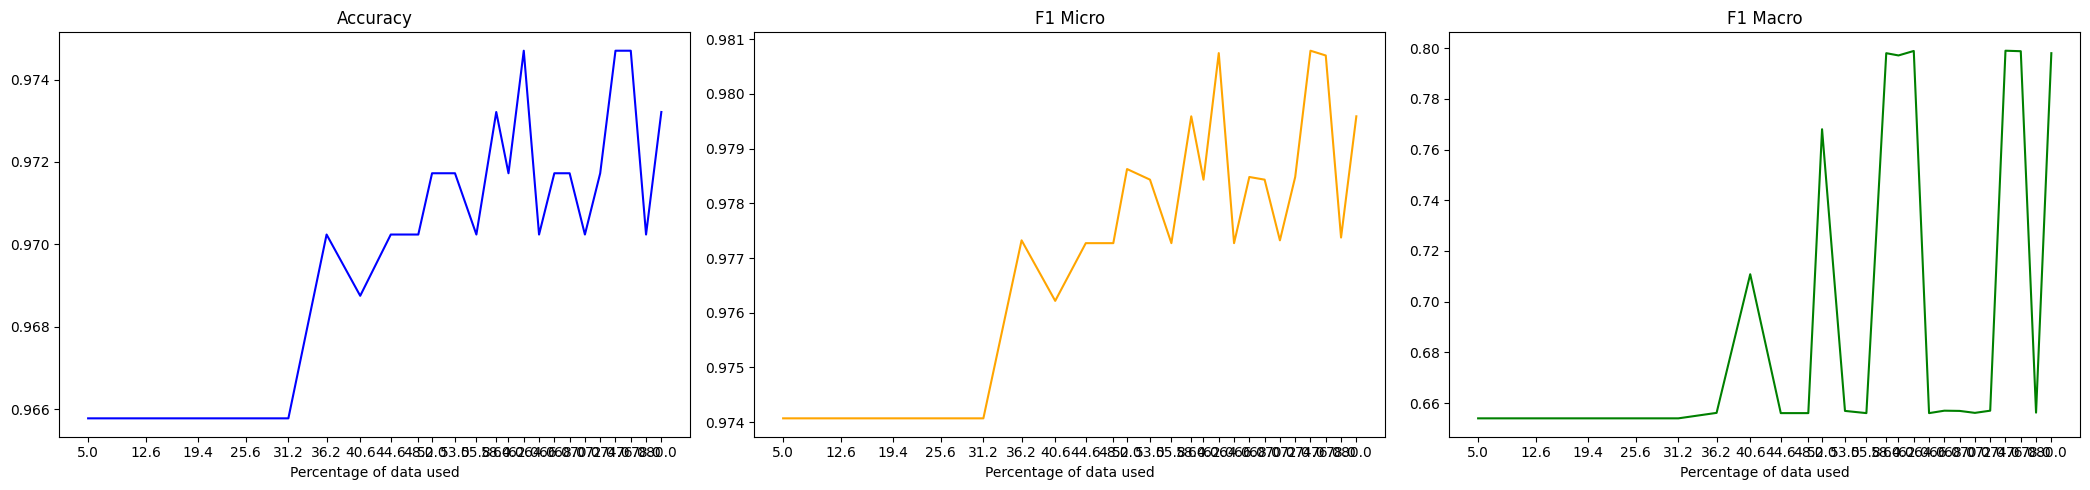

In [21]:
active_learning(seeds[4], 4)